(operator-basics)=
# Basics

The [`quimb.operator`](quimb.operator) module provides a unified way of 'symbolically' defining Hamiltonians or operators, including in symmetry sub-sectors, which can then be built into multiple different concrete representations for consumption by either the matrix or tensor network routines in quimb.

Matrix representations:

- *Dense matrix*
- *Sparse matrix*
- *Linear operator* (action on a dense vector)

Tensor network representations:

- *Matrix product operator (MPO)*
- *Dict of local dense terms* (for PEPS algorithms)
- *Projected entangled pair operator (PEPO)*

VMC routines:

- *Coupled configurations*

There is also support for certain transformations of the terms, such as the [*Jordan-Wigner* transformation](quimb.operator.SparseOperatorBuilder.jordan_wigner_transform) and [pauli decomposition](quimb.operator.SparseOperatorBuilder.pauli_decompose).

Here we'll illustrate with a 2D Heisenberg model.

In [ ]:
%config InlineBackend.figure_formats = ['svg']
import matplotlib as mpl
import matplotlib.pyplot as plt

import quimb as qu
import quimb.operator
import quimb.tensor as qtn

mpl.style.use(qu.NEUTRAL_STYLE)

## The `HilbertSpace`

For full control over the sites in our system and how to order them we first explicitly declare a [`HilbertSpace`](quimb.operator.HilbertSpace) object, here for a 2D square lattice.

In [2]:
Lx = 4
Ly = 5
sites = [(i, j) for i in range(Lx) for j in range(Ly)]
nsites = len(sites)

# define a default symmetry sector for efficiency
symmetry = "U1"
sector = nsites // 2

hilbert_space = qop.HilbertSpace(
    sites=sites,
    symmetry=symmetry,
    sector=sector,
)
hilbert_space

HilbertSpace(nsites=20, total_size=184_756, symmetry=U1, sector=10)

On its own this just has a few helpful tools for enumerating the valid configurations. The terminology used here is:

- `site`: the labels of the individual sites in the system, these can be arbtirary hashable and sortable objects, e.g. our 2D coordinates above.
- `reg`: in a linear ordering of the sites, the `reg` is the integer index or 'register' of a site. This can be controlled using the `order` argument to the `HilbertSpace` constructor.

In [3]:
hilbert_space.site_to_reg((2, 3))

13

In [4]:
hilbert_space.reg_to_site(nsites - 1)

(3, 4)

Individual configurations can be referred to in three ways:

- `config`: a dict of site to local state.
- `flatconfig`: a `numpy.ndarray[uint8]` of local states in register order.
- `rank`: an integer between 0 and `hilbert_space.size - 1` indexing the configurations in lexicographically sorted order.

In [5]:
# the first configuration (00..011..1) as a dict:
print(hilbert_space.rank_to_config(0))

{(0, 0): np.uint8(0), (0, 1): np.uint8(0), (0, 2): np.uint8(0), (0, 3): np.uint8(0), (0, 4): np.uint8(0), (1, 0): np.uint8(0), (1, 1): np.uint8(0), (1, 2): np.uint8(0), (1, 3): np.uint8(0), (1, 4): np.uint8(0), (2, 0): np.uint8(1), (2, 1): np.uint8(1), (2, 2): np.uint8(1), (2, 3): np.uint8(1), (2, 4): np.uint8(1), (3, 0): np.uint8(1), (3, 1): np.uint8(1), (3, 2): np.uint8(1), (3, 3): np.uint8(1), (3, 4): np.uint8(1)}


In [6]:
# get a random configuration
config = hilbert_space.rand_config(seed=42)
print(config)

{(0, 0): np.uint8(0), (0, 1): np.uint8(0), (0, 2): np.uint8(0), (0, 3): np.uint8(1), (0, 4): np.uint8(1), (1, 0): np.uint8(1), (1, 1): np.uint8(0), (1, 2): np.uint8(0), (1, 3): np.uint8(1), (1, 4): np.uint8(0), (2, 0): np.uint8(1), (2, 1): np.uint8(1), (2, 2): np.uint8(0), (2, 3): np.uint8(0), (2, 4): np.uint8(0), (3, 0): np.uint8(1), (3, 1): np.uint8(1), (3, 2): np.uint8(1), (3, 3): np.uint8(0), (3, 4): np.uint8(1)}


In [7]:
# find its rank
hilbert_space.config_to_rank(config)

16489

In [8]:
# the last configuration (11..100..0) as a flat vector
hilbert_space.rank_to_flatconfig(hilbert_space.size - 1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=uint8)

## The `SparseOperatorBuilder`

Now we can 'symbolically' define operators for this Hilbert space using the [`SparseOperatorBuilder`](quimb.operator.SparseOperatorBuilder) object. Here we'll define a 2D Heisenberg Hamiltonian:

In [9]:
H = qop.SparseOperatorBuilder(hilbert_space=hilbert_space)

# add nearest neighbor Heisenberg interactions
for i in range(Lx):
    for j in range(Ly):
        if i < Lx - 1:
            H += 0.5, ("+", (i, j)), ("-", (i + 1, j))
            H += 0.5, ("-", (i, j)), ("+", (i + 1, j))
            H += 1.0, ("z", (i, j)), ("z", (i + 1, j))
        if j < Ly - 1:
            H += 0.5, ("+", (i, j)), ("-", (i, j + 1))
            H += 0.5, ("-", (i, j)), ("+", (i, j + 1))
            H += 1.0, ("z", (i, j)), ("z", (i, j + 1))

# and a single site magnetic field to break symmetry
H += -0.1, ("z", (0, 0))

```{note}
If you don't supply a `HilbertSpace` then the operator builder will build the default one for the minimal set of sites in has seen so far.
```

We can see all the terms visually with the `show` method (again the ordering is given by the register order):

In [10]:
H.show()

SparseOperatorBuilder(nsites=20, nterms=94, locality=2)
+ . . . . - . . . . . . . . . . . . . .  +0.5
- . . . . + . . . . . . . . . . . . . .  +0.5
z . . . . z . . . . . . . . . . . . . .  +1.0
+ - . . . . . . . . . . . . . . . . . .  +0.5
- + . . . . . . . . . . . . . . . . . .  +0.5
z z . . . . . . . . . . . . . . . . . .  +1.0
. + . . . . - . . . . . . . . . . . . .  +0.5
. - . . . . + . . . . . . . . . . . . .  +0.5
. z . . . . z . . . . . . . . . . . . .  +1.0
. + - . . . . . . . . . . . . . . . . .  +0.5
. - + . . . . . . . . . . . . . . . . .  +0.5
. z z . . . . . . . . . . . . . . . . .  +1.0
. . + . . . . - . . . . . . . . . . . .  +0.5
. . - . . . . + . . . . . . . . . . . .  +0.5
. . z . . . . z . . . . . . . . . . . .  +1.0
. . + - . . . . . . . . . . . . . . . .  +0.5
. . - + . . . . . . . . . . . . . . . .  +0.5
. . z z . . . . . . . . . . . . . . . .  +1.0
. . . + . . . . - . . . . . . . . . . .  +0.5
. . . - . . . . + . . . . . . . . . . .  +0.5
. . . z . . . . z . . . 

Currently the supported local operators are:
```python
{
    "I": {0: (0, 1.0), 1: (1, 1.0)},
    # pauli matrices
    "x": {0: (1, 1.0), 1: (0, 1.0)},
    "y": {0: (1, 1.0j), 1: (0, -1.0j)},
    "z": {0: (0, 1.0), 1: (1, -1.0)},
    # ZX=iY: 'real Y'
    "⧖": {0: (1, -1.0), 1: (0, 1.0)},
    # spin 1/2 matrices (scaled paulis)
    "sx": {0: (1, 0.5), 1: (0, 0.5)},
    "sy": {0: (1, 0.5j), 1: (0, -0.5j)},
    "sz": {0: (0, 0.5), 1: (1, -0.5)},
    # creation / annihilation operators
    "+": {0: (1, 1.0)},
    "-": {1: (0, 1.0)},
    # number, symmetric number, and hole operators
    "n": {1: (1, 1.0)},
    "sn": {0: (0, -0.5), 1: (1, 0.5)},
    "h": {0: (0, 1.0)},
}
```

### Building matrices

Now we can build out concrete realizations of the operator. For example the sparse matrix representation:

```{hint}
By default this will pick up the default `sector` and `symmetry` from the hilbert space object, or you can explicitly override it here.
```

In [11]:
%%time
H_sparse = H.build_sparse_matrix()
H_sparse

CPU times: user 992 ms, sys: 180 ms, total: 1.17 s
Wall time: 1.18 s


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3199196 stored elements and shape (184756, 184756)>

This allows us to find the full exact groundstate and energy:

In [12]:
%%time
energy, psi = qu.eigh(H_sparse, k=1)

CPU times: user 5.01 s, sys: 82.5 ms, total: 5.09 s
Wall time: 694 ms


In [13]:
energy

array([-32.01392954])

Now we can define some other operators that act on the same hilbert space, and measure their expectation, here the Z magnetization acting on every site:

In [14]:
zijs = [[None for j in range(Ly)] for i in range(Lx)]

for i in range(Lx):
    for j in range(Ly):
        zop_ij = qop.SparseOperatorBuilder(
            # we can supply all the terms at construction
            terms=[(1.0, ("z", (i, j)))],
            # because we only act on 1 site of many, we do
            # need to explicitly provide the hilbert space
            hilbert_space=hilbert_space,
        )

        # build the sparse matrix
        zsparse_ij = zop_ij.build_sparse_matrix()

        # evaluate <psi|Z_ij|psi>
        zijs[i][j] = qu.expec(psi, zsparse_ij)

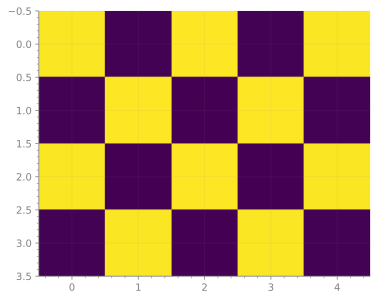

In [15]:
plt.imshow(zijs)

If this was a smaller space we could also build the full dense matrix with
[`build_dense_matrix`](quimb.operator.SparseOperatorBuilder.build_dense_matrix).

The [`SparseOperatorBuilder`](quimb.operator.SparseOperatorBuilder) also has a
[`matvec`](quimb.operator.SparseOperatorBuilder.matvec) method which computes the action on a dense vector without forming the explicit matrix. You can use this directly or call [`.aslinearoperator`](quimb.operator.SparseOperatorBuilder.aslinearoperator) to get a [`scipy.sparse.linalg.LinearOperator`](scipy.sparse.linalg.LinearOperator) object which can be used with [`scipy.sparse.linalg`](scipy.sparse.linalg) routines.

```{warning}
This is not a very efficient implementation yet, you may want to consider for example [`quspin`](https://quspin.github.io/QuSpin/) if performance is critical.
```

### Building tensor network representations

#### Building MPOs for MPS algorithms

We can also build out concrete representations of the operator for consumption by various tensor network algorithms in [`quimb.tensor`](quimb.tensor).

For example as a matrix product operator (MPO) using [`build_mpo`](quimb.operator.SparseOperatorBuilder.build_mpo):

In [16]:
H_mpo = H.build_mpo()
H_mpo

MatrixProductOperator(tensors=20, indices=59, L=20, max_bond=17)

The algorithm to build the MPO is a greedy algorithm that works well for local Hamiltonians, but will not be optimal for complicated long range models. You can check the underyling finite state machine representatino with [`draw_state_machine`](quimb.operator.SparseOperatorBuilder.draw_state_machine):

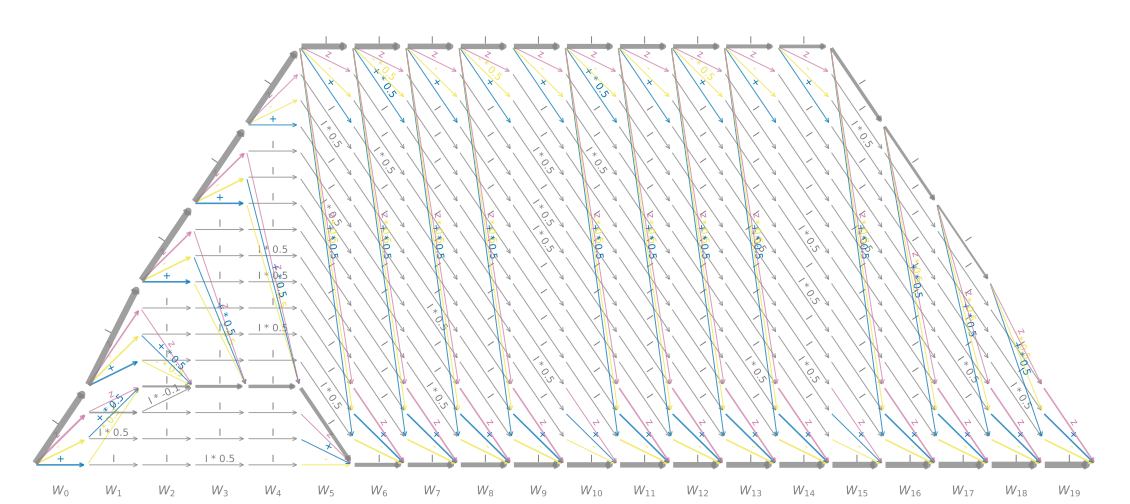

In [17]:
H.draw_state_machine()

We can use the MPO to find the groundstate with [`DMRG`](quimb.tensor.tensor_dmrg.DMRG):

In [18]:
dmrg = qtn.DMRG2(H_mpo)
dmrg.solve(verbosity=1)

1, R, max_bond=(8/8), cutoff:1e-08


100%|##########################################| 19/19 [00:00<00:00, 306.08it/s]

Energy: -31.656832428772546 ... not converged.
2, R, max_bond=(8/16), cutoff:1e-08



100%|##########################################| 19/19 [00:00<00:00, 362.23it/s]

Energy: -31.813407135272556 ... not converged.
3, R, max_bond=(16/32), cutoff:1e-08



100%|##########################################| 19/19 [00:00<00:00, 279.30it/s]

Energy: -31.818448856710024 ... not converged.
4, R, max_bond=(29/64), cutoff:1e-08



100%|##########################################| 19/19 [00:00<00:00, 192.93it/s]

Energy: -31.81932769634487 ... not converged.
5, R, max_bond=(39/128), cutoff:1e-08



100%|##########################################| 19/19 [00:00<00:00, 152.65it/s]

Energy: -31.81949636476171 ... not converged.
6, R, max_bond=(42/256), cutoff:1e-08



100%|##########################################| 19/19 [00:00<00:00, 210.71it/s]

Energy: -31.819509858329468 ... converged!


np.True_

Then we can check the relative error in the groundstate energy:

In [19]:
1 - dmrg.energy / energy.item()

np.float64(0.006072971495561852)

#### Building local terms for PEPS

For projected entangled pair states (PEPS) algorithms we often need the local terms of the Hamiltonian as dense matrices. We can build these with [`build_local_ham`](quimb.operator.SparseOperatorBuilder.build_local_ham):

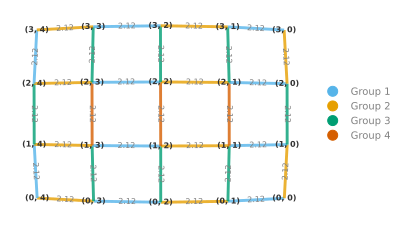

(<Figure size 547.214x547.214 with 1 Axes>, <Axes: >)

In [20]:
H_local = H.build_local_ham()
H_local.draw()

We can then feed this into algorithms such as [`simple update`](quimb.tensor.tensor_arbgeom_tebd.SimpleUpdateGen):

In [21]:
peps = qtn.PEPS.rand(Lx, Ly, 4, seed=42)
su = qtn.SimpleUpdate(peps, H_local)
su.evolve(100, tau=0.1)

n=100, D=4, tau=0.1, energy≈-31.9678: 100%|##########| 100/100 [00:02<00:00, 35.70it/s]


In [22]:
1 - su.energy / energy.item()

0.0014423055073261581

### Monte carlo usage

For variational monte carlo (VMC) or other monte carlo routines one needs to the compute the 'local energy'. This is encapsulated in the [`config_coupling`](quimb.operator.SparseOperatorBuilder.config_coupling) and [`flatconfig_coupling`](quimb.operator.SparseOperatorBuilder.flatconfig_coupling) methods. These return a tuple with A) the coupled configurations and B) the corresponding coefficients.

Mathematically, for a given configuration $| x \rangle$, this returns the non-zero coupled configurations: $\{| y \rangle\} $, as well as the coefficients $\{ \langle x | H | y \rangle \}$ such that the 'local energy' is given by:

$$
E_{\text{loc}}(x) = \sum_j \dfrac{ \langle x | H | y \rangle \langle y | \psi \rangle } { \langle x | \psi \rangle }
$$

In [23]:
flatconfig = hilbert_space.rand_flatconfig(seed=42)
flatconfig

array([0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
      dtype=uint8)

In [24]:
coupled_flatconfigs, coupled_coeffs = H.flatconfig_coupling(flatconfig)
coupled_flatconfigs, coupled_coeffs

(array([[1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1],
        [0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0]],
       dtype=uint8)

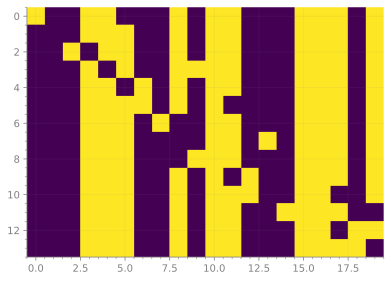

In [25]:
plt.imshow(coupled_flatconfigs)

### Transforming operators

The [`SparseOperatorBuilder`](quimb.operator.SparseOperatorBuilder) also has some methods for transforming the terms.

#### Jordan-Wigner transformation

For example the [*Jordan-Wigner* transformation](quimb.operator.SparseOperatorBuilder.jordan_wigner_transform) which maps spin-1/2 operators to fermionic ones:

In [26]:
Lx = 4
Ly = 3
sites = [(s, i, j) for s in ("u", "d") for i in range(Lx) for j in range(Ly)]
nsites = len(sites)

# define half filling in each species
symmetry = "U1U1"
sector = (nsites // 2, nsites // 4), (nsites // 2, nsites // 4)

hilbert_space = qop.HilbertSpace(
    sites=sites,
    symmetry=symmetry,
    sector=sector,
)
hilbert_space

HilbertSpace(nsites=24, total_size=853_776, symmetry=U1U1, sector=((12, 6), (12, 6)))

In [27]:
H = qop.SparseOperatorBuilder(hilbert_space=hilbert_space)

t = 1.0
U = 8.0

# add nearest neighbor Heisenberg interactions
for i in range(Lx):
    for j in range(Ly):
        for s in ("u", "d"):
            # hopping
            if i < Lx - 1:
                # the relative ordering within the term now matters too
                H.add_term(-t, ("+", (s, i, j)), ("-", (s, i + 1, j)))
                H.add_term(-t, ("+", (s, i + 1, j)), ("-", (s, i, j)))
            if j < Ly - 1:
                H.add_term(-t, ("+", (s, i, j)), ("-", (s, i, j + 1)))
                H.add_term(-t, ("+", (s, i, j + 1)), ("-", (s, i, j)))

        # interaction
        H.add_term(U, ("n", ("u", i, j)), ("n", ("d", i, j)))

```{note}
You can either call the method
[`jordan_wigner_transform`](quimb.operator.SparseOperatorBuilder.jordan_wigner_transform)
to toggle the transformation, or supply `jordan_wigner=True` to the
[`SparseOperatorBuilder`](quimb.operator.SparseOperatorBuilder) constructor.
```

In [28]:
H.jordan_wigner_transform()
H.show()

SparseOperatorBuilder(nsites=24, nterms=80, locality=4, jordan_wigner=True)
+ z z - . . . . . . . . . . . . . . . . . . . .  -1.0
- z z + . . . . . . . . . . . . . . . . . . . .  -1.0
+ - . . . . . . . . . . . . . . . . . . . . . .  -1.0
- + . . . . . . . . . . . . . . . . . . . . . .  -1.0
. . . . . . . . . . . . + z z - . . . . . . . .  -1.0
. . . . . . . . . . . . - z z + . . . . . . . .  -1.0
. . . . . . . . . . . . + - . . . . . . . . . .  -1.0
. . . . . . . . . . . . - + . . . . . . . . . .  -1.0
n . . . . . . . . . . . n . . . . . . . . . . .  +8.0
. + z z - . . . . . . . . . . . . . . . . . . .  -1.0
. - z z + . . . . . . . . . . . . . . . . . . .  -1.0
. + - . . . . . . . . . . . . . . . . . . . . .  -1.0
. - + . . . . . . . . . . . . . . . . . . . . .  -1.0
. . . . . . . . . . . . . + z z - . . . . . . .  -1.0
. . . . . . . . . . . . . - z z + . . . . . . .  -1.0
. . . . . . . . . . . . . + - . . . . . . . . .  -1.0
. . . . . . . . . . . . . - + . . . . . . . . .  -1.0
. n . 

In [29]:
H_sparse = H.build_sparse_matrix()
H_sparse

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16686516 stored elements and shape (853776, 853776)>

In [30]:
energy, psi = qu.eigh(H_sparse, k=1)
energy / (Lx * Ly)

array([-0.40943827])

#### Pauli Decomposition

You can also decompose an operator into strings of Pauli operators using the
[`pauli_decompose`](quimb.operator.SparseOperatorBuilder.pauli_decompose) method,
or by supplying `pauli_decompose=True` to the
[`SparseOperatorBuilder`](quimb.operator.SparseOperatorBuilder) constructor.
The `use_zx` argument enables decomposing Y operators into the real combination of
Z and X (i.e. ⴵ = ZX = iY) to avoid complex coefficients:

In [31]:
H.pauli_decompose(use_zx=True)
H.show()

SparseOperatorBuilder(nsites=24, nterms=105, locality=4, jordan_wigner=True, pauli_decompose=zx)
x z z x . . . . . . . . . . . . . . . . . . . .  -0.5
ⴵ z z ⴵ . . . . . . . . . . . . . . . . . . . .  +0.5
x x . . . . . . . . . . . . . . . . . . . . . .  -0.5
ⴵ ⴵ . . . . . . . . . . . . . . . . . . . . . .  +0.5
. . . . . . . . . . . . x z z x . . . . . . . .  -0.5
. . . . . . . . . . . . ⴵ z z ⴵ . . . . . . . .  +0.5
. . . . . . . . . . . . x x . . . . . . . . . .  -0.5
. . . . . . . . . . . . ⴵ ⴵ . . . . . . . . . .  +0.5
z . . . . . . . . . . . . . . . . . . . . . . .  -2.0
. . . . . . . . . . . . z . . . . . . . . . . .  -2.0
z . . . . . . . . . . . z . . . . . . . . . . .  +2.0
. x z z x . . . . . . . . . . . . . . . . . . .  -0.5
. ⴵ z z ⴵ . . . . . . . . . . . . . . . . . . .  +0.5
. x x . . . . . . . . . . . . . . . . . . . . .  -0.5
. ⴵ ⴵ . . . . . . . . . . . . . . . . . . . . .  +0.5
. . . . . . . . . . . . . x z z x . . . . . . .  -0.5
. . . . . . . . . . . . . ⴵ z z ⴵ . . .

### Builtin operators

The following hamiltonians are built in:

- [`heisenberg_from_edges`](quimb.operator.heisenberg_from_edges): the Heisenberg model on an arbitrary graph defined by `edges`, includes the transverse field ising model as a special case of the coupling and magnetic field terms.
- [`fermi_hubbard_from_edges`](quimb.operator.fermi_hubbard_from_edges): the Fermi-Hubbard model on an arbitrary graph defined by `edges`.
- [`fermi_hubbard_spinless_from_edges`](quimb.operator.fermi_hubbard_spinless_from_edges): the spinless Fermi-Hubbard model (aka t-V model) on an arbitrary graph defined by `edges`.